# 1. Introduction and Imports

## 1.1. Problem Overview

This [Kaggle Competition](https://www.kaggle.com/competitions/tabular-playground-series-jul-2022/overview) serves as an introduction to unsupervised clustering problems.

We are given a dataset where each row belongs to a particular cluster and our job is to predict the cluster each row belongs to.

We are not given any training data and we are not told how many clusters are found in the ground truth labels - this is a completely unsupervised problem.

The evaluation metric is Adjusted Rand Index between the ground truth cluster labels of the data and our predicted cluster levels.

## 1.2. Import Libraries

In [1]:
#Core libraries
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture

#Clustering evaluation
from yellowbrick.cluster import KElbowVisualizer

#Preprocessing
from sklearn.preprocessing import PowerTransformer

#Dimensionality reduction
from sklearn.decomposition import PCA

# 2. Load and Explore Data

## 2.1. Load Data

The following code reads the data and saves it as a Pandas DataFrame.

In [2]:
#Load data
data = pd.read_csv("/kaggle/input/tabular-playground-series-jul-2022/data.csv")

## 2.2. Inspect Data

In [3]:
#Look at first rows of data
data.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


The data has an id column and 29 features called f_00, f_01, ..., f_28.

We don't know what these features mean.

## 2.3. Data Types

In [4]:
#Set id as index
data = data.set_index('id')

#Look at data types of features
data.dtypes.value_counts()

float64    22
int64       7
Name: count, dtype: int64

The data only contains float and integer data types, so we don't need to worry about encoding string features.

## 2.4. Missing Values

In [5]:
#Look for missing values
data.isna().sum().sum()

0

The data doesn't have any missing values, so imputation won't be necessary neither.

# 3. Data Preprocessing

## 3.1. Correlation Matrix

Let's take a look at how our features are correlated between each other.

Features with zero correlation with all the other features don't help in clustering - they are just noise.

If we detect any of these, we can get rid of them and reduce dimension.

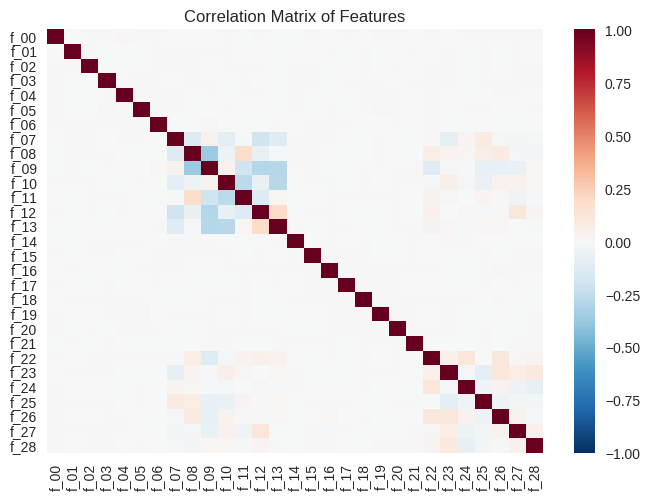

In [6]:
#Plot correlation matrix
sns.heatmap(data=data.corr(),
            annot=False,
            vmin=-1,
            vmax=1,
            cmap='RdBu_r')
plt.title('Correlation Matrix of Features')
plt.show()

## 3.2. Features Selection

Almost half of the features have zero correlation with all the others, so we can get rid of them and reduce dimension.

In [7]:
#Select features with correlation
features= ['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13',
           'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']

#Get rid of features with no correlation
filtered_data = data[features]

## 3.3. Normalization

Clustering algorithms are sensitive to scaling and asymetries, so we will normalize all the features.

We will use the [Yeo-Johnson transformation](en.wikipedia.org/wiki/Power_transform), which also works with negative values like we have.

In [8]:
#Define transformer
transformer = PowerTransformer(method='yeo-johnson', standardize=True)

#Normalize all data
normalized_data = pd.DataFrame(transformer.fit_transform(filtered_data),
                               index=filtered_data.index,
                               columns=filtered_data.columns)

# 4. Modeling

## 4.1. Elbow Method

### 4.1.1. Boxplot

Before applying clustering algorithms, we remove outliers to improve the accuracy of the elbow method.

The elbow method helps us determine the optimal number of clusters by identifying where adding more clusters no longer significantly reduces within-cluster variance.

A boxplot will help us identify ouliers.

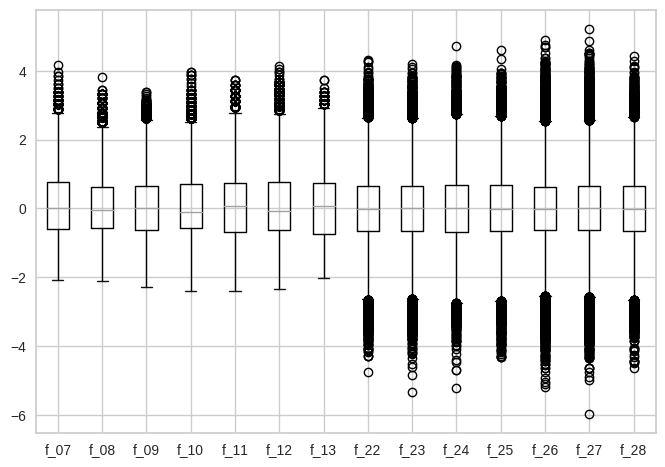

In [9]:
#Look at boxplot
normalized_data.boxplot(column=features);

### 4.1.2. Outliers Removal

The following code removes the outliers of the normalized data.

In [10]:
def remove_outliers(df, features):
    
    #List with outlier indexes
    outlier_rows = []
    
    #Look for each feature
    for col in features:
        #Calculate Q1 and Q3
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        #Calculate IQR
        IQR = Q3 - Q1
        
        #Define limits
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        #Look for outliers
        for index, value in df[col].items():
            if value < lower_limit or value > upper_limit:
                #Add index to outlier_rows
                outlier_rows.append(index)
    
    #Get rid of duplicates with set()
    outlier_rows = list(set(outlier_rows))
    
    #Drop outliers
    return df.drop(outlier_rows, axis=0)

#Remove outliers from our scaled data
no_outliers_data = remove_outliers(normalized_data, features)

#Prin how many rows were removed
print("NUMBER OF ROWS")
print(f"Original data: {data.shape[0]}")
print(f"After removing outliers: {no_outliers_data.shape[0]}")

NUMBER OF ROWS
Original data: 98000
After removing outliers: 89554


### 4.1.3. Elbow Visualization

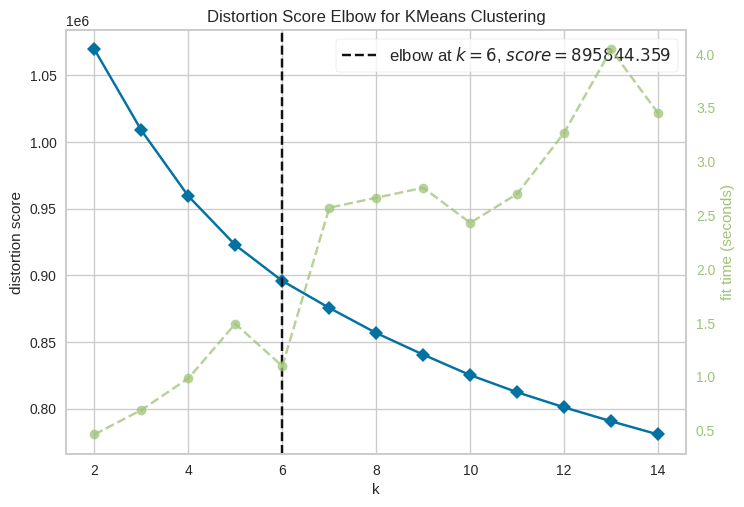

In [11]:
#Visualize elbow method
visualizer = KElbowVisualizer(KMeans(n_init=10, random_state=0), k=(2, 15), metric='distortion');
visualizer.fit(no_outliers_data);
visualizer.show();

Remember the distortion score is calculated as

$$
\text{Distortion (Inertia)} = \sum_{i=1}^K \sum_{x \in C_i} \| x - \mu_i \|^2 ,
$$

where K is the number of clusters, $C_i$ are the clusters the algorithm made and $\mu_i$ is the centroid of each cluster.

Informally, the elbow is defined as the number of clusters where distortion no longer significantly reduces as we keep adding more clusters.

Formally, the elbow is the number of clusters where the distortion curve has maximum curvature.

The results show the elbow stands at K=6 even though the curve is very smooth, so there is not a clear number of clusters in the data.

## 4.2. K-Means Clustering

The following code applies the K-Means Clustering algorithm to the data, with six number of clusters.

In [12]:
#K-Means using six clusters
kmeans = KMeans(n_clusters=6, n_init=10, random_state=0)
normalized_data['KMeans'] = kmeans.fit_predict(normalized_data)

#Look at first rows
normalized_data.head()

,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28,KMeans
id,,,,,,,,,,,,,,,
0,-0.977987,1.383372,1.039938,-0.567775,1.142180,-0.083596,0.086073,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234,3
1,-0.977987,-0.875405,-0.179925,-0.837020,-0.420725,1.725834,0.738456,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652,2
2,0.021718,1.017648,-0.394246,0.124844,0.296135,-0.928325,1.118063,2.203065,0.086974,-1.519163,-0.568662,0.978900,-0.926277,-2.296373,3
3,0.286548,-1.213526,0.917564,0.124844,0.296135,-0.083596,-0.434221,0.731623,-1.218086,0.826492,-1.173592,-0.395085,-0.100021,0.326682,5
4,0.756900,0.187543,-0.394246,-1.135381,-1.954502,1.271662,1.118063,0.228337,-1.482684,0.847999,-0.613935,1.164389,-0.374203,-1.160058,4


## 4.3. Bayesian Gaussian Mixture

We will also use Bayesian Gaussian Mixture (BGM), another clustering algorithm.

While K-Means assigns points to a cluster based on the distance from the centroid, Bayesian Gaussian Mixture uses probabilities of points belonging to each cluster.

For this reason, Bayesian Gaussian Mixture models may capture non-spherical clusters better.

In [13]:
#BGM using six clusters
BGM = BayesianGaussianMixture(n_components=6, random_state=0)
normalized_data['BGM'] = BGM.fit_predict(normalized_data[features])

#Look at first rows
normalized_data.head()

,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28,KMeans,BGM
id,,,,,,,,,,,,,,,,
0,-0.977987,1.383372,1.039938,-0.567775,1.142180,-0.083596,0.086073,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234,3,3
1,-0.977987,-0.875405,-0.179925,-0.837020,-0.420725,1.725834,0.738456,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652,2,4
2,0.021718,1.017648,-0.394246,0.124844,0.296135,-0.928325,1.118063,2.203065,0.086974,-1.519163,-0.568662,0.978900,-0.926277,-2.296373,3,3
3,0.286548,-1.213526,0.917564,0.124844,0.296135,-0.083596,-0.434221,0.731623,-1.218086,0.826492,-1.173592,-0.395085,-0.100021,0.326682,5,5
4,0.756900,0.187543,-0.394246,-1.135381,-1.954502,1.271662,1.118063,0.228337,-1.482684,0.847999,-0.613935,1.164389,-0.374203,-1.160058,4,0


## 4.4. Principal Component Analysis

### 4.4.1. Explained Variance

In this section we will visualize how the clusters partitioned the data.

In order to do this, we will use PCA to reduce dimension and get the two axes with highest variance.

Let's first look at how much explained variance would be captured with the two main principal components.

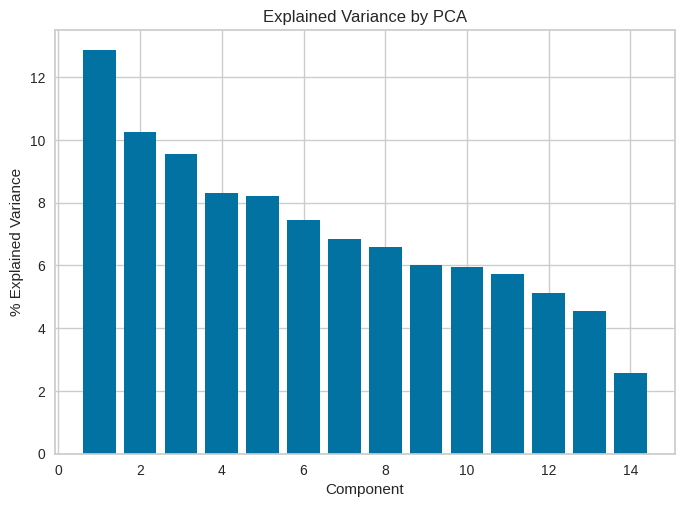

In [14]:
#Apply PCA
pca = PCA()
data_pca = pca.fit_transform(normalized_data[features])

#Convert to DataFrame
component_names = [f"PC{i+1}" for i in range(data_pca.shape[1])]
data_pca = pd.DataFrame(data_pca, columns=component_names)

#Plot explained variances
n = pca.n_components_
evr = pca.explained_variance_ratio_ * 100
plt.bar(np.arange(1, n+1), evr);
plt.xlabel('Component')
plt.ylabel('% Explained Variance')
plt.title('Explained Variance by PCA');

### 4.4.2. Cluster Visualization

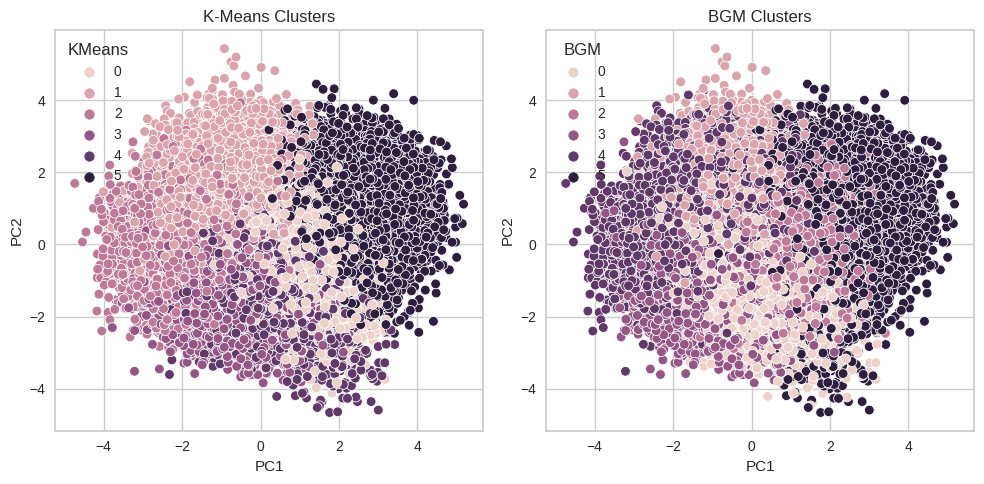

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#Visualize K-Means clusters
sns.scatterplot(x=data_pca['PC1'], y=data_pca['PC2'], hue=normalized_data['KMeans'], ax=axs[0]);
axs[0].set_title('K-Means Clusters')

#Visualize BGM clusters
sns.scatterplot(x=data_pca['PC1'], y=data_pca['PC2'], hue=normalized_data['BGM'], ax=axs[1]);
axs[1].set_title('BGM Clusters')

plt.tight_layout()
plt.show()

Even though the two main principal components only explain 23% of the total variance, we still got a chance to see how the two clustering algorithms partitioned the data.

## 5. Submission

## 5.1. Create Output Files

The following code creates two submission files for the clustering partition of both algorithms.

These will be submitted on the Competition.

In [16]:
kmeans_output = pd.DataFrame({'Id': normalized_data.index, 'Predicted': normalized_data['KMeans']})
kmeans_output.to_csv('kmeans_submission.csv', index=False)

BGM_output = pd.DataFrame({'Id': normalized_data.index, 'Predicted': normalized_data['BGM']})
BGM_output.to_csv('bgm_submission.csv', index=False)

## 5.2. Conclusions and Learnings

In section 3 we learned that there is a subset of the features that have zero correlation with all the others - they are just noise.

By removing them we can focus on the features that will be useful for clustering - specifically these are f_07 to f_13 and f_22 to f_28.

After submission, we had an Adjusted Rand Index score of 0.28514 with the K-Means clusters and 0.55702 with the BGM clusters.

This might be an indicator that some clusters are non-spherical - minimizing distances to the centroid didn't work very well.

Overall, this was my first unsupervised learning project and I hope to do more difficult and long ones in the future.

Thanks for reading!